# Registry of Open Datasets: GDELT

The GDELT project monitors the world's broadcast, print, and web news from nearly every corner of every country in over 100 languages and identifies the people, locations, organizations, counts, themes, sources, emotions, quotes, images and events driving our global society every second of every day.

## Global threators

Analyzing threats issued between countries and visualizing the aggressiveness as a network.


#### References


[GDELT project](<https://www.gdeltproject.org>)

[GDELT Events Data Schema](<https://www.gdeltproject.org/data/lookups/SQL.tablecreate.txt>)


<http://alvinalexander.com/source-code/scala-java-lang-nosuchmethoderror-compiler-message/>

<https://databricks.com/blog/2019/12/05/processing-geospatial-data-at-scale-with-databricks.html>

<https://docs.databricks.com/spark/latest/graph-analysis/graphframes/graph-analysis-tutorial.html>

In [0]:
from pyspark.sql.functions import col, lit, when, desc

### ETL: define schema for reading the data from the s3 bucket

In [0]:
%sql

-- https://www.gdeltproject.org/data/lookups/SQL.tablecreate.txt

CREATE TABLE gdelt_2019_hist (
 GLOBALEVENTID int, 
 SQLDATE int , 
 MonthYear string , 
 Year string , 
 FractionDate double , 
 Actor1Code string , 
 Actor1Name string , 
 Actor1CountryCode string , 
 Actor1KnownGroupCode string , 
 Actor1EthnicCode string , 
 Actor1Religion1Code string , 
 Actor1Religion2Code string , 
 Actor1Type1Code string , 
 Actor1Type2Code string , 
 Actor1Type3Code string , 
 Actor2Code string , 
 Actor2Name string , 
 Actor2CountryCode string , 
 Actor2KnownGroupCode string , 
 Actor2EthnicCode string , 
 Actor2Religion1Code string , 
 Actor2Religion2Code string , 
 Actor2Type1Code string , 
 Actor2Type2Code string , 
 Actor2Type3Code string , 
 IsRootEvent int , 
 EventCode string , 
 EventBaseCode string , 
 EventRootCode string , 
 QuadClass int , 
 GoldsteinScale double , 
 NumMentions int , 
 NumSources int , 
 NumArticles int , 
 AvgTone double , 
 Actor1Geo_Type int , 
 Actor1Geo_FullName string , 
 Actor1Geo_CountryCode string , 
 Actor1Geo_ADM1Code string , 
 Actor1Geo_Lat float , 
 Actor1Geo_Long float , 
 Actor1Geo_FeatureID int , 
 Actor2Geo_Type int , 
 Actor2Geo_FullName string , 
 Actor2Geo_CountryCode string , 
 Actor2Geo_ADM1Code string , 
 Actor2Geo_Lat float , 
 Actor2Geo_Long float , 
 Actor2Geo_FeatureID int , 
 ActionGeo_Type int , 
 ActionGeo_FullName string , 
 ActionGeo_CountryCode string , 
 ActionGeo_ADM1Code string , 
 ActionGeo_Lat float , 
 ActionGeo_Long float , 
 ActionGeo_FeatureID int , 
 DATEADDED int

)

In [0]:
gdelt = spark.table("gdelt_2019_hist")
gdelt.printSchema()

root
-- GLOBALEVENTID: integer (nullable = true)
-- SQLDATE: integer (nullable = true)
-- MonthYear: string (nullable = true)
-- Year: string (nullable = true)
-- FractionDate: double (nullable = true)
-- Actor1Code: string (nullable = true)
-- Actor1Name: string (nullable = true)
-- Actor1CountryCode: string (nullable = true)
-- Actor1KnownGroupCode: string (nullable = true)
-- Actor1EthnicCode: string (nullable = true)
-- Actor1Religion1Code: string (nullable = true)
-- Actor1Religion2Code: string (nullable = true)
-- Actor1Type1Code: string (nullable = true)
-- Actor1Type2Code: string (nullable = true)
-- Actor1Type3Code: string (nullable = true)
-- Actor2Code: string (nullable = true)
-- Actor2Name: string (nullable = true)
-- Actor2CountryCode: string (nullable = true)
-- Actor2KnownGroupCode: string (nullable = true)
-- Actor2EthnicCode: string (nullable = true)
-- Actor2Religion1Code: string (nullable = true)
-- Actor2Religion2Code: string (nullable = true)
-- Actor2Type1Code: string (nullable = true)
-- Actor2Type2Code: string (nullable = true)
-- Actor2Type3Code: string (nullable = true)
-- IsRootEvent: integer (nullable = true)
-- EventCode: string (nullable = true)
-- EventBaseCode: string (nullable = true)
-- EventRootCode: string (nullable = true)
-- QuadClass: integer (nullable = true)
-- GoldsteinScale: double (nullable = true)
-- NumMentions: integer (nullable = true)
-- NumSources: integer (nullable = true)
-- NumArticles: integer (nullable = true)
-- AvgTone: double (nullable = true)
-- Actor1Geo_Type: integer (nullable = true)
-- Actor1Geo_FullName: string (nullable = true)
-- Actor1Geo_CountryCode: string (nullable = true)
-- Actor1Geo_ADM1Code: string (nullable = true)
-- Actor1Geo_Lat: float (nullable = true)
-- Actor1Geo_Long: float (nullable = true)
-- Actor1Geo_FeatureID: integer (nullable = true)
-- Actor2Geo_Type: integer (nullable = true)
-- Actor2Geo_FullName: string (nullable = true)
-- Actor2Geo_CountryCode: string (nullable = true)
-- Actor2Geo_ADM1Code: string (nullable = true)
-- Actor2Geo_Lat: float (nullable = true)
-- Actor2Geo_Long: float (nullable = true)
-- Actor2Geo_FeatureID: integer (nullable = true)
-- ActionGeo_Type: integer (nullable = true)
-- ActionGeo_FullName: string (nullable = true)
-- ActionGeo_CountryCode: string (nullable = true)
-- ActionGeo_ADM1Code: string (nullable = true)
-- ActionGeo_Lat: float (nullable = true)
-- ActionGeo_Long: float (nullable = true)
-- ActionGeo_FeatureID: integer (nullable = true)
-- DATEADDED: integer (nullable = true)

### Read data from the s3 bucket into a dataframe

In [0]:
df = spark.read.option("header", "false").format("csv").option('delimiter', '\t').load("s3://gdelt-open-data/events/2019*", schema=gdelt.schema)

In [0]:
display(df.groupBy("EventRootCode").count())

EventRootCode,count
07,1395071
15,128576
11,2745118
01,5863354
16,400598
18,642342
17,2108992
09,842229
05,3336142
19,2453391


### Read in GDELT event codes to extract threats from the events raw data

- Define edges and nodes of the graph based on country codes and number of threats emitted

- Store threat edges and nodes in database tables

In [0]:
import pandas as pd
eventcode_data_types = {'CAMEOEVENTCODE': str, 'EVENTDESCRIPTION': str}
eventcodes = pd.read_csv('https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt', sep="\t", dtype=eventcode_data_types)
eventcodes.head()

,CAMEOEVENTCODE,EVENTDESCRIPTION
0,01,MAKE PUBLIC STATEMENT
1,010,"Make statement, not specified below"
2,011,Decline comment
3,012,Make pessimistic comment
4,013,Make optimistic comment


In [0]:
eventcodes.loc[eventcodes['CAMEOEVENTCODE']=='13']

,CAMEOEVENTCODE,EVENTDESCRIPTION
197,13,THREATEN


In [0]:
threats_df = df.filter(df['EventRootCode'] == '13')

In [0]:
threatVertex = threats_df.select('Actor1Geo_FullName', 'Actor1Geo_CountryCode').distinct()
threatVertex = (threatVertex
  .withColumnRenamed("Actor1Geo_FullName", "name")
  .withColumnRenamed("Actor1Geo_CountryCode", "id")).where(col("id").isNotNull())
display(threatVertex)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-632836474838741> in <module> 
 ----> 1 threatVertex = threats_df . select ( 'Actor1Geo_FullName' , 'Actor1Geo_CountryCode' ) . distinct ( ) 
 2 threatVertex = (threatVertex
 3 . withColumnRenamed ( "Actor1Geo_FullName" , "name" ) 
 4 .withColumnRenamed("Actor1Geo_CountryCode", "id")).where(col("id").isNotNull())
 5 display ( threatVertex ) 

 NameError : name 'threats_df' is not defined

In [0]:
threatEdges = (threats_df.select("Actor1Geo_CountryCode", "Actor2Geo_CountryCode", 'GoldsteinScale')
  .withColumnRenamed("Actor1Geo_CountryCode", "src")
  .withColumnRenamed("Actor2Geo_CountryCode", "dst")
              .withColumnRenamed("GoldsteinScale", "gscale")).where(col("src").isNotNull() & col("dst").isNotNull())


In [0]:
type(threatEdges)

Out[29]: pyspark.sql.dataframe.DataFrame

In [0]:
display(threatEdges)

src,dst,gscale
AS,CH,-4.4
AS,CH,-4.4
IS,IS,-4.4
IS,IS,-4.4
AS,CH,-4.4
AS,AS,-4.4
AS,AS,-4.4
BA,BA,-4.4
CH,US,-4.4
US,US,-4.4


In [0]:
threatVertex.write.saveAsTable("threat_vertices")
threatEdges.write.saveAsTable("threat_edges_")

# Analysis

In [0]:
vertices = spark.table("threat_vertices").where(col("id").isNotNull())
edges = spark.table("threat_edges_").where(col("src").isNotNull() & col("dst").isNotNull() & (col("src") != col("dst")))

In [0]:

from graphframes import GraphFrame

threatGraph = GraphFrame(vertices, edges)
# GraphFrame?

In [0]:
topThreaters = (threatGraph
  .edges
  .groupBy("src", "dst")
  .count()
  .orderBy(desc("count"))
#   .limit(10)
)

display(topThreaters)

src,dst,count
US,IR,2542
IR,US,2537
CH,US,1849
US,CH,1806
US,RS,1549
RS,US,1391
IS,IR,1362
IR,UK,1161
IR,IS,1152
PK,IN,1095


In [0]:
threaters_pdf = topThreaters.toPandas()
threaters_pdf.head()

,src,dst,count
0,US,IR,2542
1,IR,US,2537
2,CH,US,1849
3,US,CH,1806
4,US,RS,1549


In [0]:
len(threaters_pdf)

Out[26]: 4996

In [0]:
!pip install networkx

In [0]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
top_threaters_pdf = threaters_pdf.head(300)
top_threaters_pdf.head()

,src,dst,count
0,US,IR,2542
1,IR,US,2537
2,CH,US,1849
3,US,CH,1806
4,US,RS,1549


In [0]:
edges = [[src, dst] for src, dst in zip(top_threaters_pdf['src'], top_threaters_pdf['dst'])]
edges_labels = {(src, dst):cnt for src, dst, cnt in zip(top_threaters_pdf['src'], top_threaters_pdf['dst'], top_threaters_pdf['count'])}

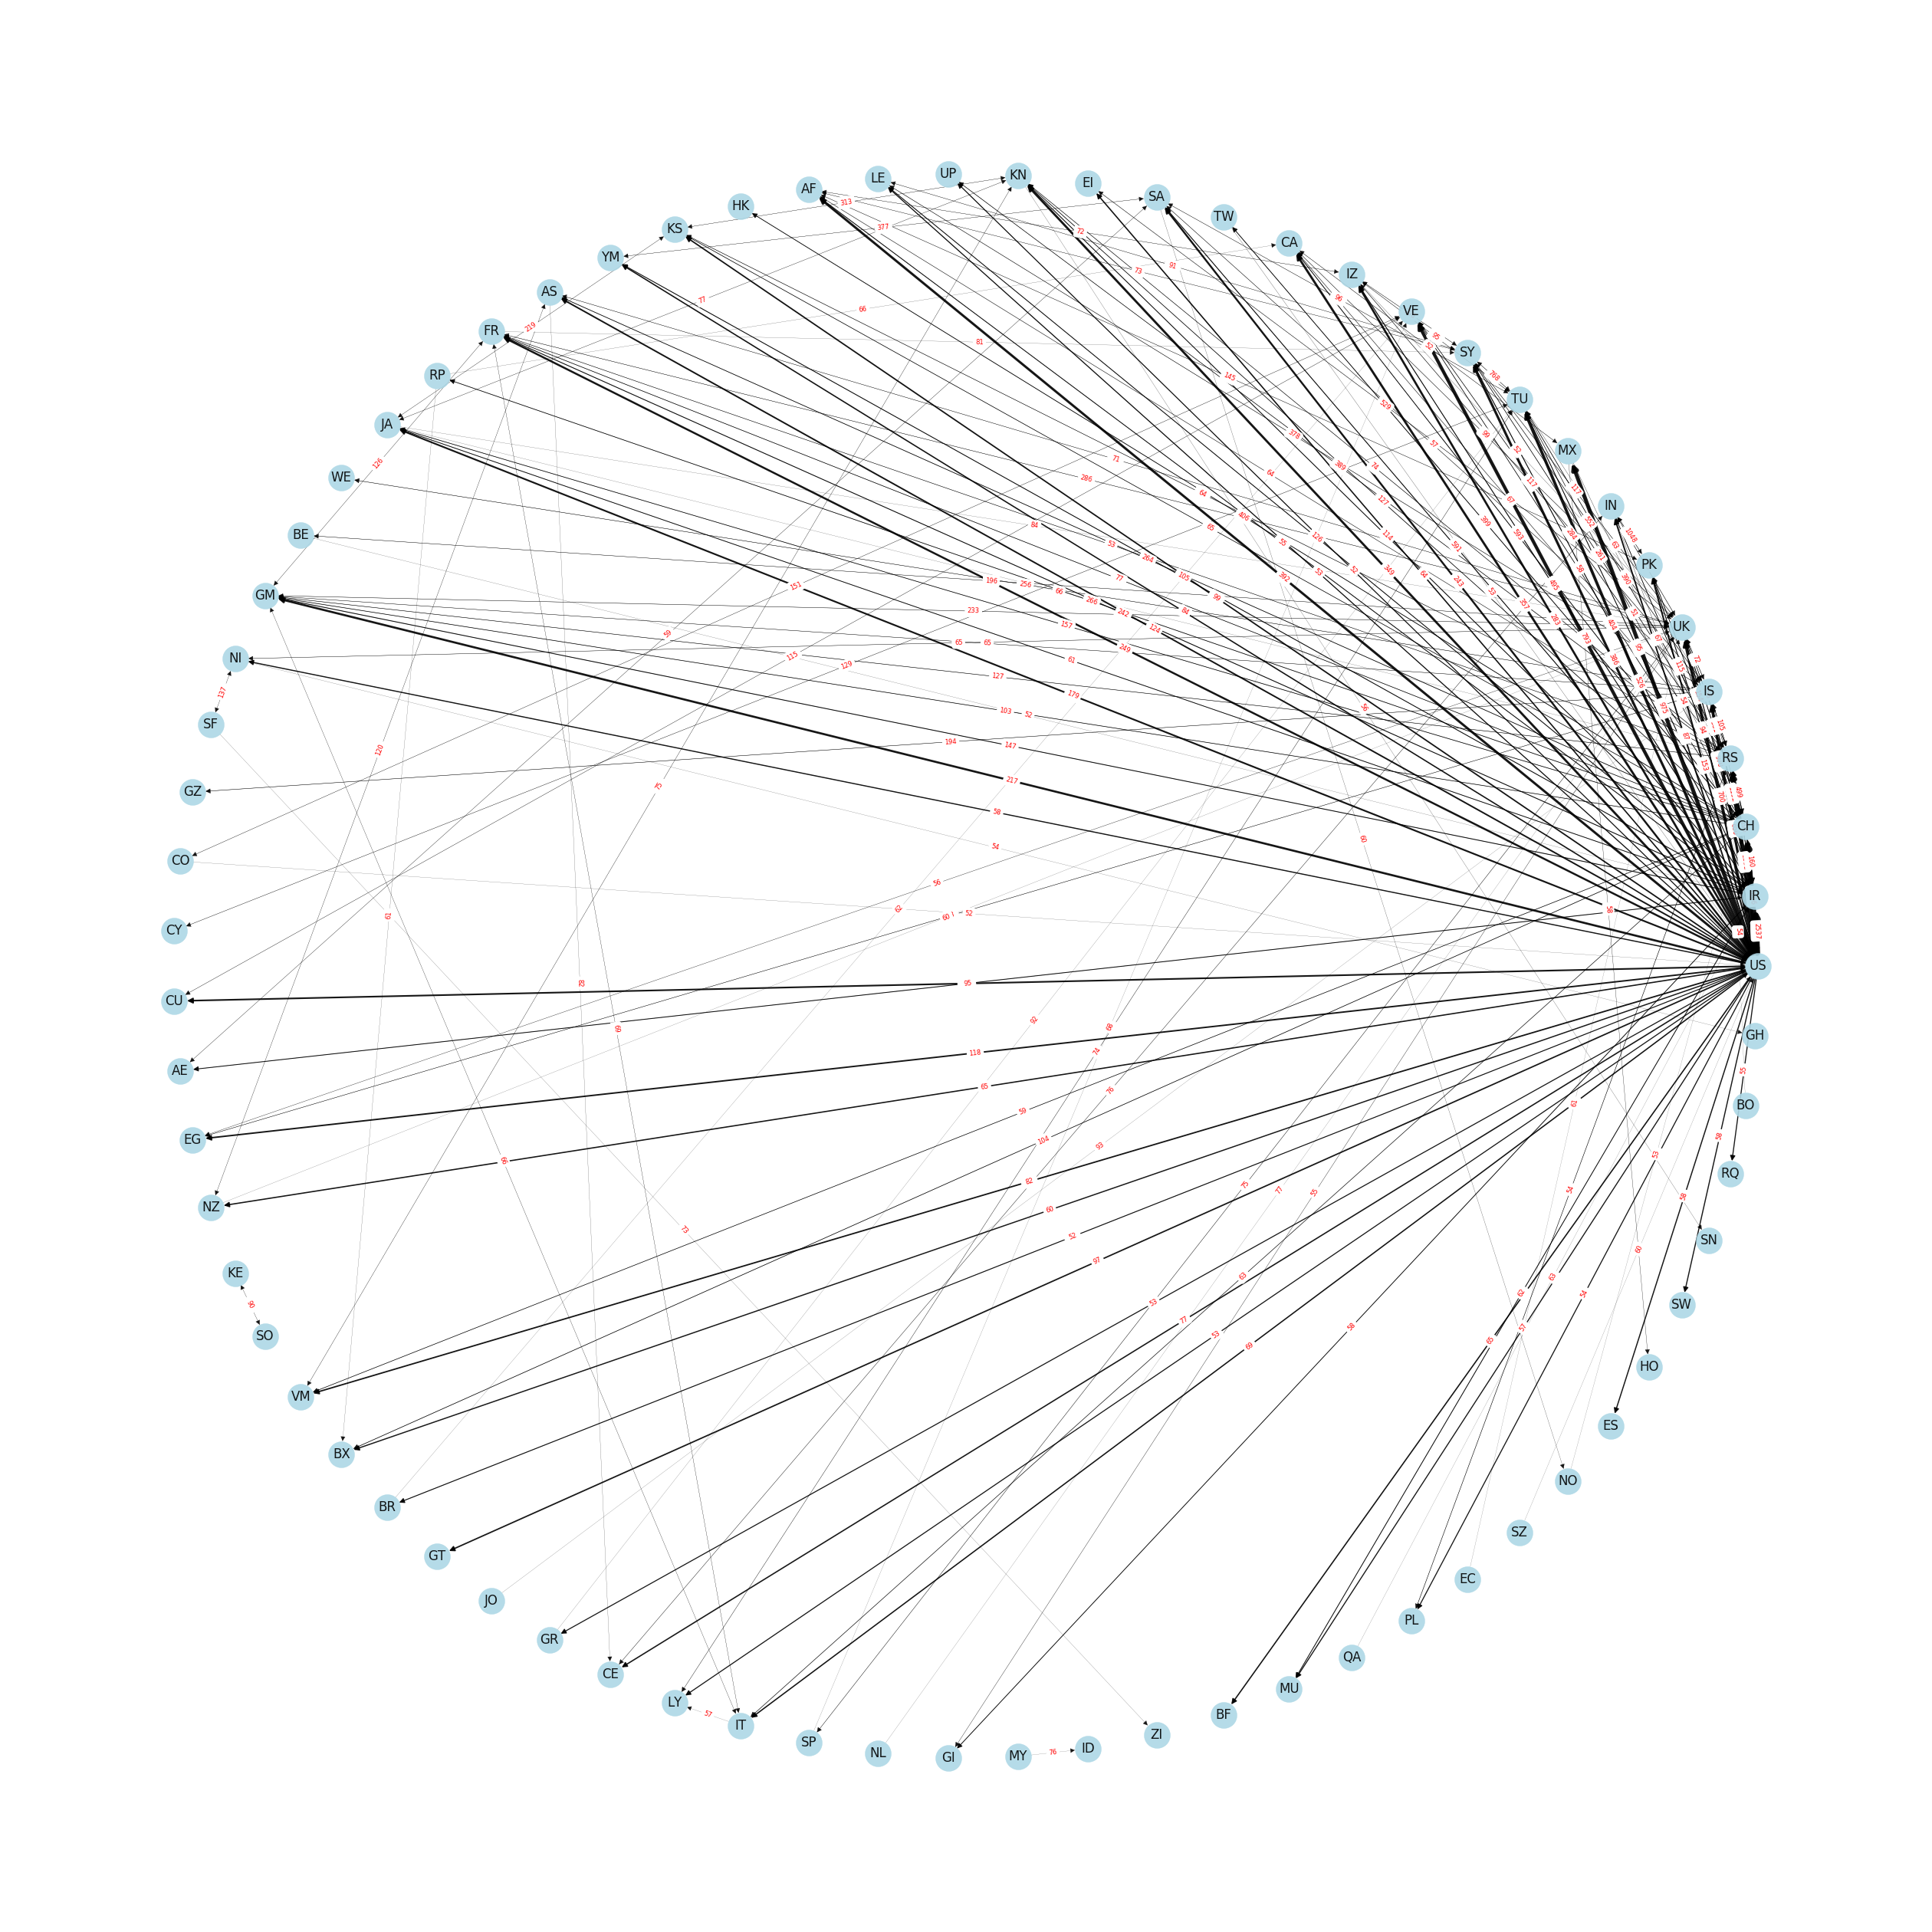

In [0]:
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.circular_layout(G)
width = top_threaters_pdf['count'].values/top_threaters_pdf['count'].mean()*0.5

fig = plt.figure(figsize=(25, 25))    
nx.draw(G, pos, edge_color='black', width=width, linewidths=0.3,
        node_size=600,node_color='lightblue',alpha=0.9,
        labels={node:node for node in G.nodes()})

nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels, font_color='red', font_size=6)
plt.axis('off')


display(fig)